In [30]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import imdb
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, LSTM, Bidirectional
import re

Спробуємо завантажити датасет і глянути, що там всередині

In [2]:
(input_train, y_train), (input_test, y_test) = imdb.load_data()

In [3]:
input_train[:10]

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1

In [4]:
y_train[:100]

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0], dtype=int64)

In [5]:
word_index = imdb.get_word_index()

In [6]:
inverted_word_index = dict((i, word) for (word, i) in word_index.items())

In [7]:
inverted_word_index[1]

'the'

In [8]:
len(word_index)

88584

З опису датасету відомо, що індех слова відповідає частоті його появи у відгуках (чим частіше, тим менший індекс).

Повний словник містить понад 88 тисяч слів, але з точки зору моделі кожне слово є окремою фічею, тож полегшимо життя мому немолодому ноуту і обмежимо дані тільки 10 тисячами слів.

Перезавантажимо дані

In [9]:
max_fitures = 10000
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_fitures)

In [10]:
input_train[:10]

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 8255, 78, 228,

Помічаємо, що в закодованих рецензіях слова з індексом, що перевищує 10000, замінені на 2 (out-of-vocabulary character), перше слово завжди 1 (START), індекси в закодованих рецензіях і словнику відрізняються на 3. 

Перепишемо словник декодування і напишемо функцію що читає рецензію (декодує).


In [11]:
inverted_word_index = dict((i+3, word) for (word, i) in word_index.items())
inverted_word_index[1] = "START"
inverted_word_index[2] = "OOV"

In [12]:
def read_review(encoded_list):
    rewiev = [inverted_word_index[i] for i in encoded_list]
    return " ".join(rewiev)

print(read_review(input_train[0]))
print("Цей відгук виглядає позитивним і відповідає 1 з y_train")
print(read_review(input_train[1]))
print("Цей відгук виглядає негативним і відповідає 0 з y_train")


START this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert OOV is an amazing actor and now the same being director OOV father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for OOV and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also OOV to the two little boy's that played the OOV of norman and paul they were just brilliant children are often left out of the OOV list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have do

Декодувати навчились, тепер спробуємо написати функцію, що кодуватиме рецензію у потрібний нам формат.

Для прикладу візьмемо пару рецензій з IMDB на фільм Jai Bhim (2021)

In [13]:
positive_review = '''
The film is based on true story which was happened 28 years ago.

Despite given an 'A' rating for its strong content, the film was real and brutal what we see it is similar to Visaranai and Kavalthurai Ungal Nanban. This is one of the best and powerful legal films. Thus, it's a must.watch.'''

negative_review = """
If you see it as a work of art, it is a good product.but the political alignment has made the entire effort go in vain.. movies should be taken for all sections of people and shouldn't discriminate any particular group to comfort the political masters agenda."""


In [14]:
def encode_review(review):
    reg = re.compile("a-zA-Z ")
    str2encode = reg.sub(" ", review).lower().split()
    encoded = [1]
    for word in str2encode:
        if word in word_index.keys() and word_index[word] < max_fitures:
            encoded.append(word_index[word]+3)
        else:
            encoded.append(2)

    return encoded

read_review(encode_review(negative_review))

"START if you see it as a work of OOV it is a good OOV the political OOV has made the entire effort go in OOV movies should be taken for all sections of people and shouldn't OOV any particular group to comfort the political masters OOV"

Схоже, працює.

І нарешті здійснемо ще один крок, а саме визначемо розмір вектора рацензії і приведемо всі рецензії до цього розміру.

In [15]:
max_len = 1000
input_train = pad_sequences(input_train, maxlen=max_len)
input_test = pad_sequences(input_test, maxlen=max_len)
positive_encoded = pad_sequences(np.array([encode_review(positive_review)]), maxlen=max_len)
negative_encoded = pad_sequences(np.array([encode_review(negative_review)]), maxlen=max_len)

In [16]:
# Створимо функцію, для швидкого виведення історії втрат та точності
def present_histiry(title, history_data):
    figure, axis = plt.subplots(ncols=2, figsize=(15,10))

    axis[0].plot(history_data.history["loss"], label="train loss")
    axis[0].plot(history_data.history["val_loss"], label="valid loss")
    # axis[0].title(title + ": loss")
    axis[0].grid()
    axis[0].legend()
    #plt.show()

    axis[1].plot(history_data.history["accuracy"], label="train accuracy")
    axis[1].plot(history_data.history["val_accuracy"], label="valid accuracy")
    # axis[1].title(title + ": accuracy")
    axis[1].grid()
    axis[1].legend()

    figure.suptitle(title + f" max val accuracy {max(history_data.history['val_accuracy'])}")
    
    plt.show()


Приступимо до побудови моделі

In [22]:
model = Sequential()

model.add(Embedding(max_fitures, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", "binary_crossentropy"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 322113 (1.23 MB)
Trainable params: 322113 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
history = model.fit(input_train, y_train, batch_size=128, validation_split=0.2, epochs=15, shuffle=True)


Epoch 1/15
157/157 [==============================] - 55s 341ms/step - loss: 0.6806 - accuracy: 0.5558 - binary_crossentropy: 0.6806 - val_loss: 0.6412 - val_accuracy: 0.6450 - val_binary_crossentropy: 0.6412
Epoch 2/15
157/157 [==============================] - 54s 344ms/step - loss: 0.4676 - accuracy: 0.7971 - binary_crossentropy: 0.4676 - val_loss: 0.4727 - val_accuracy: 0.7872 - val_binary_crossentropy: 0.4727
Epoch 3/15
157/157 [==============================] - 54s 345ms/step - loss: 0.3276 - accuracy: 0.8695 - binary_crossentropy: 0.3276 - val_loss: 0.4049 - val_accuracy: 0.8252 - val_binary_crossentropy: 0.4049
Epoch 4/15
157/157 [==============================] - 53s 335ms/step - loss: 0.2473 - accuracy: 0.9039 - binary_crossentropy: 0.2473 - val_loss: 0.3564 - val_accuracy: 0.8634 - val_binary_crossentropy: 0.3564
Epoch 5/15
157/157 [==============================] - 51s 327ms/step - loss: 0.1827 - accuracy: 0.9334 - binary_crossentropy: 0.1827 - val_loss: 0.3686 - val_accura

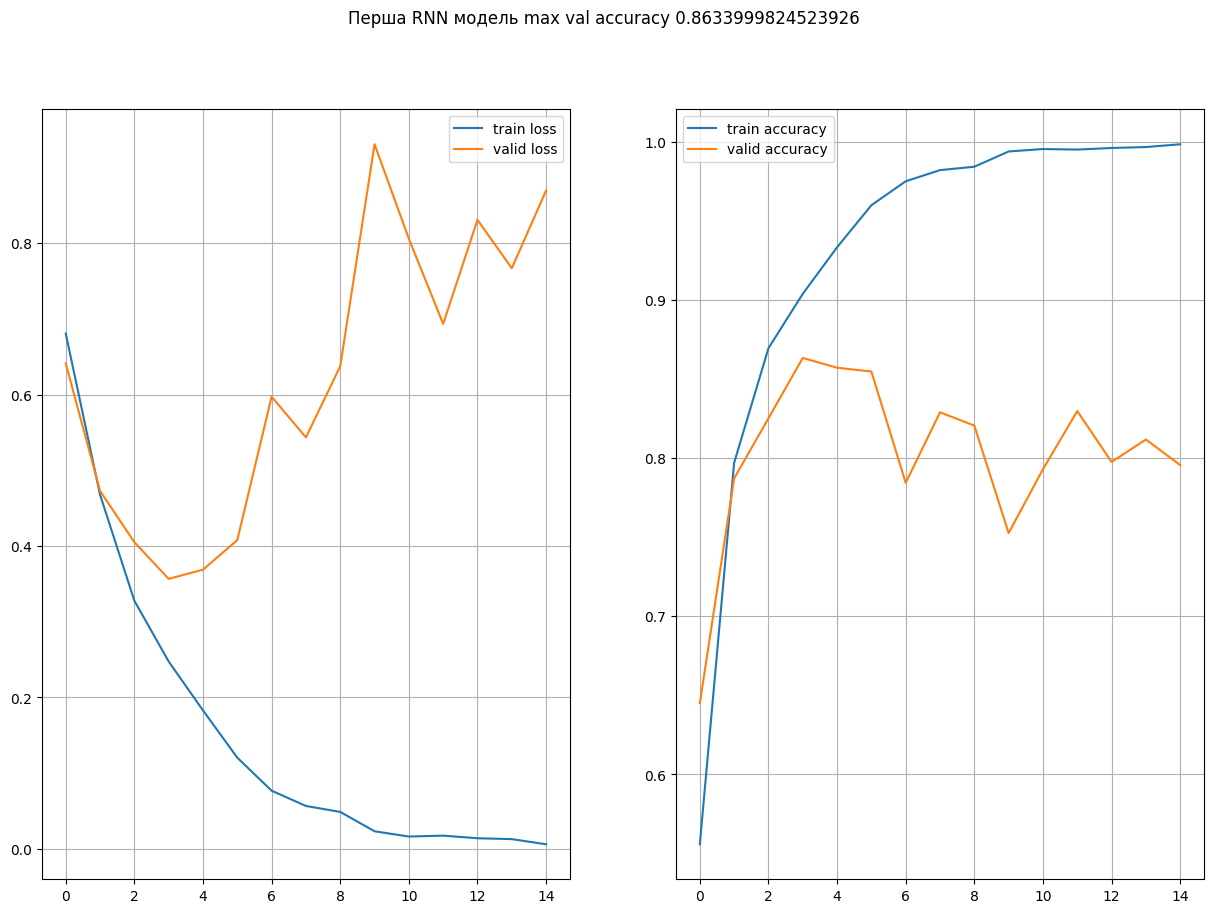

In [24]:
present_histiry("Перша RNN модель", history)

Ну що ж, спробуємо глянути, що видасть модель на наших закодованих рецензіях

In [25]:
model.predict(positive_encoded)

1/1 [==============================] - 0s 236ms/step


array([[0.96462554]], dtype=float32)

In [26]:
model.predict(negative_encoded)

1/1 [==============================] - 0s 60ms/step


array([[0.63703865]], dtype=float32)

З позитивним відгуком модель справилась чудово, однак з негативним вийшла промашка.

Оцінимо точність моделі на тестових даних з датасету Keras

In [27]:
predict_test = model.predict(input_test)
binry_predict = [1 if i>0.5 else 0 for i in predict_test]

782/782 [==============================] - 44s 56ms/step


In [29]:
test_loss, test_acc, _ = model.evaluate(input_test, y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

782/782 [==============================] - 43s 55ms/step - loss: 0.9034 - accuracy: 0.7891 - binary_crossentropy: 0.9034
Test Loss: 0.9033663272857666
Test Accuracy: 0.789080023765564


Що ж, точність отриманої моделі не є вельми високою, спробуємо іншу архітектуру.

In [35]:
lstm_model = Sequential()
lstm_model.add(Embedding(max_fitures, 32))
lstm_model.add(LSTM(32))
lstm_model.add(Dense(1, activation="sigmoid"))

lstm_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", "binary_crossentropy"])
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 32)          320000    
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 328353 (1.25 MB)
Trainable params: 328353 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
lstm_history = lstm_model.fit(input_train, y_train, batch_size=128, validation_split=0.2, epochs=10, shuffle=True)

Epoch 1/10
157/157 [==============================] - 151s 944ms/step - loss: 0.5972 - accuracy: 0.6700 - binary_crossentropy: 0.5972 - val_loss: 0.4638 - val_accuracy: 0.7710 - val_binary_crossentropy: 0.4638
Epoch 2/10
157/157 [==============================] - 148s 943ms/step - loss: 0.3672 - accuracy: 0.8458 - binary_crossentropy: 0.3672 - val_loss: 0.5163 - val_accuracy: 0.7854 - val_binary_crossentropy: 0.5163
Epoch 3/10
157/157 [==============================] - 148s 939ms/step - loss: 0.2775 - accuracy: 0.8916 - binary_crossentropy: 0.2775 - val_loss: 0.6027 - val_accuracy: 0.8084 - val_binary_crossentropy: 0.6027
Epoch 4/10
157/157 [==============================] - 144s 917ms/step - loss: 0.2314 - accuracy: 0.9120 - binary_crossentropy: 0.2314 - val_loss: 0.3962 - val_accuracy: 0.8642 - val_binary_crossentropy: 0.3962
Epoch 5/10
157/157 [==============================] - 144s 920ms/step - loss: 0.2016 - accuracy: 0.9266 - binary_crossentropy: 0.2016 - val_loss: 0.4965 - val_a

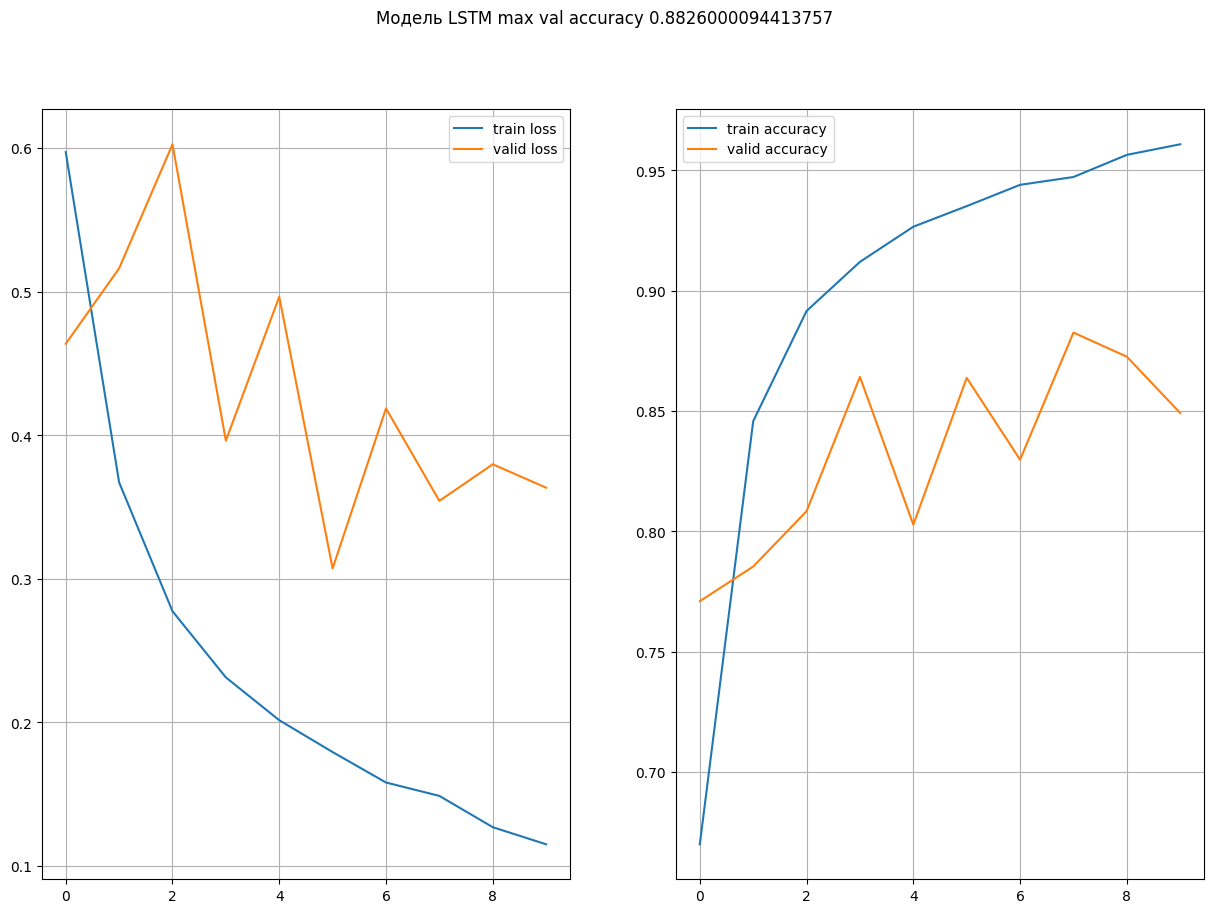

In [37]:
present_histiry("Модель LSTM", lstm_history)

Перевіримо як працює модель на тестових даних

In [38]:
lstm_model.predict(positive_encoded)

1/1 [==============================] - 1s 556ms/step


array([[0.9782813]], dtype=float32)

In [39]:
lstm_model.predict(negative_encoded)

1/1 [==============================] - 0s 78ms/step


array([[0.41237783]], dtype=float32)

Дана модель вірно оцінила позитивний відгук і краще зрозуміла негативний. Проженемо все на тестових даних

In [40]:
lstm_test_loss, lstm_test_acc, _ = lstm_model.evaluate(input_test, y_test)
print('Test Loss: {}'.format(lstm_test_loss))
print('Test Accuracy: {}'.format(lstm_test_acc))

782/782 [==============================] - 110s 141ms/step - loss: 0.3707 - accuracy: 0.8522 - binary_crossentropy: 0.3707
Test Loss: 0.37066105008125305
Test Accuracy: 0.8521599769592285


Втрати зменшились, точність виросла. Ок, побудуємо наступну модель

In [41]:
bdrnn_model = Sequential()
bdrnn_model.add(Embedding(max_fitures, 32))
bdrnn_model.add(Bidirectional(LSTM(32)))
bdrnn_model.add(Dense(1, activation="sigmoid"))

bdrnn_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", "binary_crossentropy"])
bdrnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 32)          320000    
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 336705 (1.28 MB)
Trainable params: 336705 (1.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
bdrnn_history = bdrnn_model.fit(input_train, y_train, batch_size=128, validation_split=0.2, epochs=15, shuffle=True)

Epoch 1/15
157/157 [==============================] - 337s 2s/step - loss: 0.1575 - accuracy: 0.9441 - binary_crossentropy: 0.1575 - val_loss: 0.3289 - val_accuracy: 0.8718 - val_binary_crossentropy: 0.3289
Epoch 2/15
157/157 [==============================] - 313s 2s/step - loss: 0.1423 - accuracy: 0.9508 - binary_crossentropy: 0.1423 - val_loss: 0.3108 - val_accuracy: 0.8834 - val_binary_crossentropy: 0.3108
Epoch 3/15
157/157 [==============================] - 310s 2s/step - loss: 0.1233 - accuracy: 0.9572 - binary_crossentropy: 0.1233 - val_loss: 0.3566 - val_accuracy: 0.8830 - val_binary_crossentropy: 0.3566
Epoch 4/15
157/157 [==============================] - 310s 2s/step - loss: 0.1174 - accuracy: 0.9602 - binary_crossentropy: 0.1174 - val_loss: 0.4042 - val_accuracy: 0.8662 - val_binary_crossentropy: 0.4042
Epoch 5/15
157/157 [==============================] - 308s 2s/step - loss: 0.1072 - accuracy: 0.9639 - binary_crossentropy: 0.1072 - val_loss: 0.3812 - val_accuracy: 0.8692

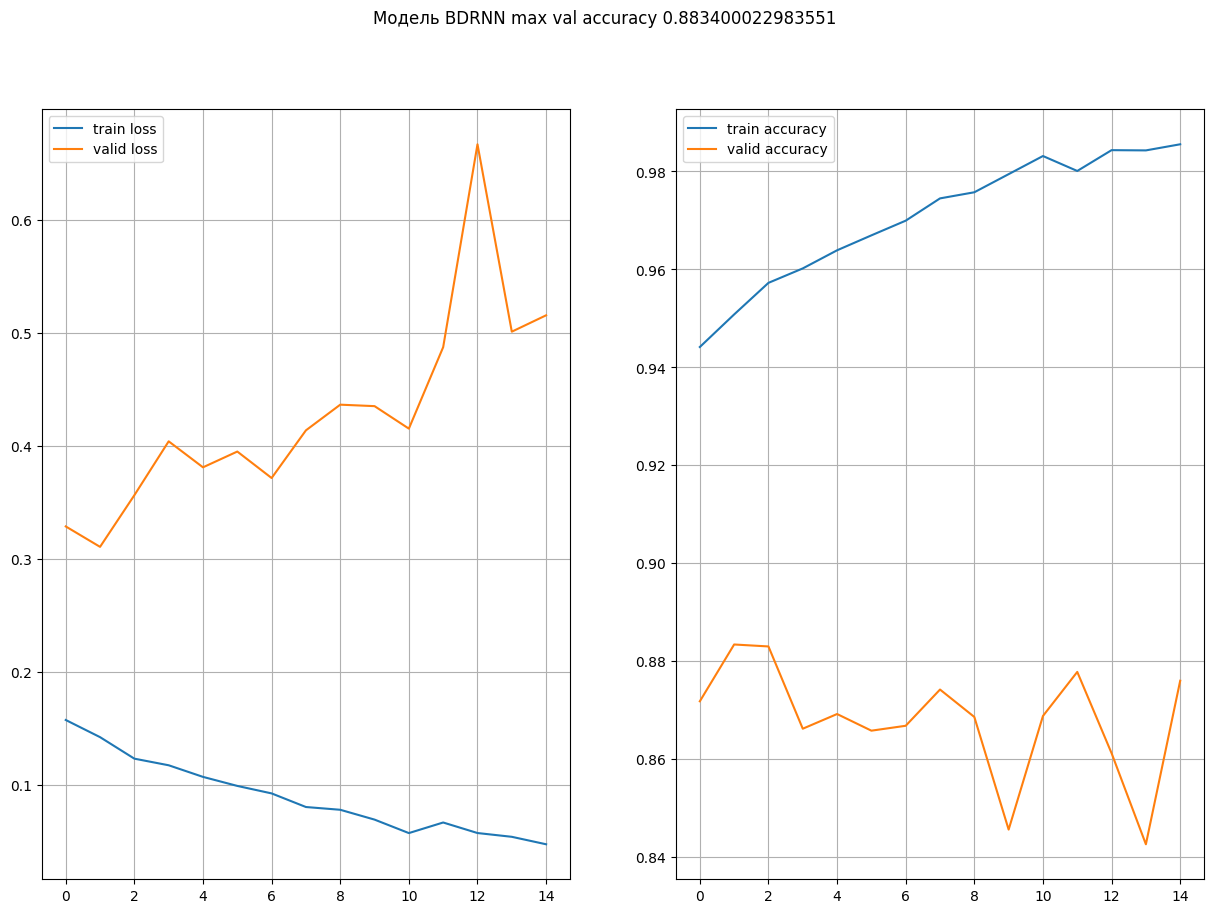

In [46]:
present_histiry("Модель BDRNN", bdrnn_history)

In [47]:
bdrnn_model.predict(positive_encoded)

1/1 [==============================] - 1s 885ms/step


array([[0.9923603]], dtype=float32)

In [48]:
bdrnn_model.predict(negative_encoded)

1/1 [==============================] - 0s 79ms/step


array([[0.48566037]], dtype=float32)

In [54]:
bdrnn_test_loss, bdrnn_test_acc, _ = bdrnn_model.evaluate(input_test, y_test)
print('Test Loss: {}'.format(bdrnn_test_loss))
print('Test Accuracy: {}'.format(bdrnn_test_acc))

782/782 [==============================] - 122s 156ms/step - loss: 0.5865 - accuracy: 0.8587 - binary_crossentropy: 0.5865
Test Loss: 0.5865141153335571
Test Accuracy: 0.858680009841919


Тестові (нові) рецензії визначились добре, але гірше, ніж в моделі LSTM. Дані по втратам та точності з evaluate. Взагалі, з даною мережею все виглядає досить дивно: найкращі результати по валідаційним втратам були після першої епохи, далі все тільки погіршувалось, модель відразу звалилась в перенавчання.

In [50]:
drnn_model = Sequential()
drnn_model.add(Embedding(max_fitures, 32))
drnn_model.add(Bidirectional(LSTM(32, return_sequences=True)))
drnn_model.add(Bidirectional(LSTM(32)))
drnn_model.add(Dense(1, activation="sigmoid"))

drnn_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", "binary_crossentropy"])
drnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 32)          320000    
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 64)          16640     
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 361537 (1.38 MB)
Trainable params: 361537 (1.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
drnn_history = drnn_model.fit(input_train, y_train, batch_size=128, validation_split=0.2, epochs=10, shuffle=True)

Epoch 1/10
157/157 [==============================] - 746s 5s/step - loss: 0.6542 - accuracy: 0.5804 - binary_crossentropy: 0.6542 - val_loss: 0.5039 - val_accuracy: 0.7694 - val_binary_crossentropy: 0.5039
Epoch 2/10
157/157 [==============================] - 724s 5s/step - loss: 0.3822 - accuracy: 0.8370 - binary_crossentropy: 0.3822 - val_loss: 0.3581 - val_accuracy: 0.8454 - val_binary_crossentropy: 0.3581
Epoch 3/10
157/157 [==============================] - 756s 5s/step - loss: 0.2751 - accuracy: 0.8915 - binary_crossentropy: 0.2751 - val_loss: 0.3629 - val_accuracy: 0.8388 - val_binary_crossentropy: 0.3629
Epoch 4/10
157/157 [==============================] - 758s 5s/step - loss: 0.2265 - accuracy: 0.9135 - binary_crossentropy: 0.2265 - val_loss: 0.3453 - val_accuracy: 0.8650 - val_binary_crossentropy: 0.3453
Epoch 5/10
157/157 [==============================] - 776s 5s/step - loss: 0.1912 - accuracy: 0.9293 - binary_crossentropy: 0.1912 - val_loss: 0.3337 - val_accuracy: 0.8558

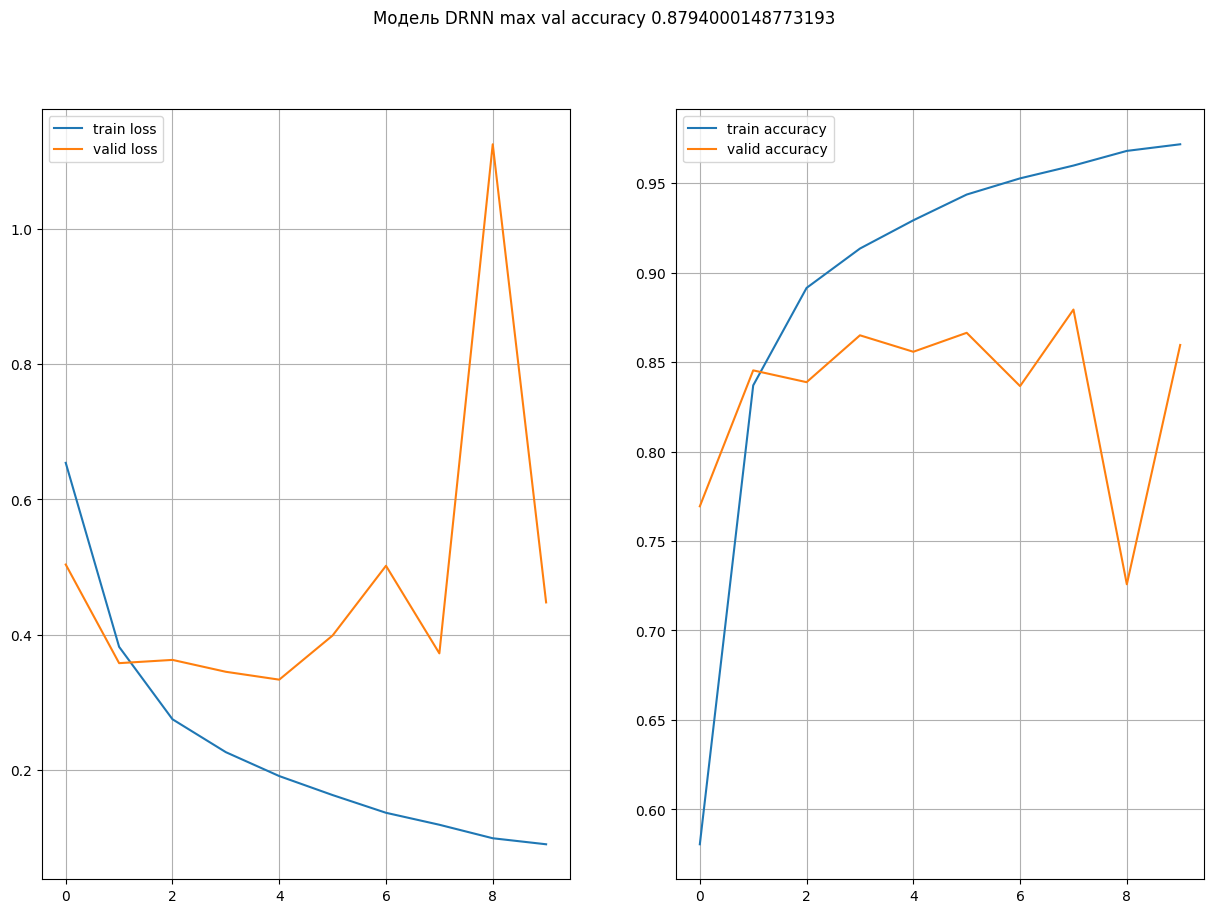

In [53]:
present_histiry("Модель DRNN", drnn_history)

In [55]:
drnn_model.predict(positive_encoded)

1/1 [==============================] - 5s 5s/step


array([[0.9893617]], dtype=float32)

In [56]:
drnn_model.predict(negative_encoded)

1/1 [==============================] - 0s 116ms/step


array([[0.91890085]], dtype=float32)

In [57]:
drnn_test_loss, drnn_test_acc, _ = drnn_model.evaluate(input_test, y_test)
print('Test Loss: {}'.format(drnn_test_loss))
print('Test Accuracy: {}'.format(drnn_test_acc))

782/782 [==============================] - 272s 348ms/step - loss: 0.4604 - accuracy: 0.8551 - binary_crossentropy: 0.4604
Test Loss: 0.460408091545105
Test Accuracy: 0.8551200032234192


Замість загальних висновків:

1. На превеликий жаль, жодна з моделей не взяла 90%
2. RNN-моделі вчаться довше (на одну епоху) і досить швидко впадають у перенавчання
3. Обробка мови, як у цьому завданні - нетривіальна задача. Негативна оцінка з IMDB, що я взяв для тесту, хоч і відповідає значенню 1 з 10, але по тексту є більше вибаченням за таку оцінку.
4. Найкращий результат показала LSTM модель, що і далі підтверджує правило - не варто занадто ускладнювати моделі. Можливо, на більшому масиві даних більш складні моделі показали б кращий результат